Notebook to:
 - read an AAVS HDF5 data file and a station YAML file,
 - convert to SDP datamodels,
 - run calibration with GSM and solar sky models, and
 - plot the results.

It requires local copies of the HDF5, YAML and EEP files.
EEP files should be converted to .npy format as described in:<br>
https://developer.skatelescope.org/projects/ska-low-mccs-calibration/en/latest/sky-models.html.<br>
e.g.
    
> from ska_low_mccs_calibration.eep import convert_eep2npy<br>
> convert_eep2npy(f"/path/to/eep/data/FEKO_AAVS3_vogel_256_elem_50ohm_*MHz_?pol.mat", npy_dir="./AAVS3_EEPs_local")<br>

In [1]:
###
### Set PATHs and file names here
###

import logging
import os
import sys
import warnings

import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants
from astropy.time import Time
from time import perf_counter

from ska_low_mccs_calibration.calibration import calibrate_mccs_visibility
from ska_low_mccs_calibration.utils import (
    read_yaml_config,
    sdp_visibility_datamodel,
)

log = logging.getLogger()
log.setLevel(logging.INFO)
log.addHandler(logging.StreamHandler(sys.stdout))

warnings.filterwarnings("ignore")

<frozen abc>:106: FutureWarning: xarray subclass Visibility should explicitly define __slots__








In [2]:
# Observation date_time
date_time = "20240119_12601"

# Observation coarse channel number (obs central freq / 781.25kHz)
channel_id = 140

corr_matrix_file_PATH = '.'
corr_matrix_file = f"correlation_burst_{channel_id}_{date_time}_0.hdf5"

eep_file_path = "./AAVS3_EEPs_local"
eep_file_base = "FEKO_AAVS3_vogel_256_elem_50ohm_"

station_configuration_file = "aavs3.yaml"

# Precision to use when building models (and when converting EEP images to npy)
model_dtype = np.complex64

# HDF5 Data File

In [3]:
datafile = h5py.File(f"{corr_matrix_file_PATH}/{corr_matrix_file}", 'r')

correlation_info = datafile['observation_info']

# Get the metadata associated with the correlation matrices

correlation_metadata = dict(datafile['root'].attrs)

ntimes = correlation_metadata['n_blocks']
int_time = correlation_metadata['tsamp']
nant = correlation_metadata['n_antennas']
nbaselines = (correlation_metadata['n_baselines'])
n_pol = correlation_metadata['n_pols']
n_stokes = correlation_metadata['n_stokes']

assert nbaselines == nant * (nant + 1) // 2, "expecting all auto and cross correlations"
assert n_stokes == 4, "data should contain 4 polarisation products"
assert correlation_metadata['n_chans'] == 1, "data should have a single frequency channel"
assert correlation_metadata['channel_id'] == channel_id, f"assuming frequency channel {channel_id}"

# chop off rounding errors
int_time = round(int_time, 12)

# Get the data associated with the correlation matrices

correlation_data = np.squeeze(datafile['correlation_matrix']['data'])
print("Shape of the correlation data: ",correlation_data.shape,\
      " time_sequence, baseline_number, pol_product")

assert correlation_data.ndim == 3
assert correlation_data.shape[0] == ntimes
assert correlation_data.shape[1] == nbaselines
assert correlation_data.shape[2] == n_stokes

### Get the timestamps associated with the correlation matrices

correlation_times = datafile['sample_timestamps']
if ntimes > 1: 
    correlation_times_array = np.squeeze(correlation_times['data'])
else:
    correlation_times_array = correlation_times['data'][0]

# the first time step has lower amplitude, so drop it
correlation_times_array = correlation_times_array[1:]
correlation_data = correlation_data[1:, :, :]
ntimes = len(correlation_times_array)

print("Final shape of the correlation data: ",correlation_data.shape,\
      " time_sequence, baseline_number, pol_product")

Shape of the correlation data:  (34, 32896, 4)  time_sequence, baseline_number, pol_product
Final shape of the correlation data:  (33, 32896, 4)  time_sequence, baseline_number, pol_product


# YAML Configuration File

In [4]:
### get the antenna locations from aavs3.yaml, which is as-built

mro_site, antenna_masks, baselines, enu, pol, rotation = read_yaml_config(station_configuration_file)

assert len(antenna_masks) == nant
assert len(baselines[0]) == nbaselines

# Convert antenna positions to numpy array for ease of use and transpose
enu = np.array(enu, dtype=model_dtype(0).real.dtype).T

# Convert yaml antenna masks to visibility masks
masked_antennas = np.where(antenna_masks==True)[0]
print("Masked antennas (zero-based indexing):", masked_antennas)

bl_flags = np.logical_or(
    np.isin(baselines[0], masked_antennas), np.isin(baselines[1], masked_antennas)
)

# May as well flag autos as well
bl_flags = np.logical_or(bl_flags, baselines[0] == baselines[1])

# stack to have the same shape as vis with common flags for XX,XY,YX,YY pol products
vis_flags = np.tile(bl_flags, (4, 1)).T

read_yaml_station: extracting station aavs3
read_yaml_config: station rotation 0.000000 deg
Masked antennas (zero-based indexing): [ 47  52  53  63  64  70  72  73  89  99 101 115 177 201 209 230]


# Package data in Visibility data model
 - https://developer.skao.int/projects/ska-sdp-datamodels/en/latest/

In [5]:
###  Package MCCS data in a ska-sdp-datamodels Visibility xarray

# Observing frequency
channel_bw_MHz = 400.0 / 512.0
frequency_MHz = float(channel_id) * channel_bw_MHz

Time_array = (Time(correlation_times_array, format='unix', location=mro_site))
Time_array.format = 'fits'

# all, average, last
time_sel = "average"
if time_sel == "average":
    # Model all separately (time consuming), model once and phase shift (should do), or just average
    time = Time_array[ntimes // 2]
    vis = sum(correlation_data) / float(ntimes)
    int_time *= ntimes
elif time_sel == "all":
    time = Time_array
    vis = correlation_data
elif time_sel == "last":
    itime = ntimes - 1
    time = Time_array[itime]
    vis = correlation_data[itime]
print(f"Selecting {int_time} seconds of data around: {time}")

v_measurement = sdp_visibility_datamodel(
    vis=vis[:, pol],
    flags=vis_flags[:, pol],
    uvw=enu[baselines[0]] - enu[baselines[1]],
    ant1=baselines[0],
    ant2=baselines[1],
    location=mro_site,
    antpos_enu=enu,
    time=time,
    int_time=int_time,
    frequency_mhz=frequency_MHz,
)

Selecting 65.39968512 seconds of data around: 2024-01-19T03:35:20.358


# Run calibration
 - Includes the generation of models visibilities from PyGDSM + solar sky models and EEP images.
 - Uses https://developer.skao.int/projects/ska-sdp-func-python/en/latest/ calibration routines.

In [6]:
# Show some extra output
log.setLevel(logging.DEBUG)

# Whether or not to refit with a polarised solver
#  Note that the solar model cannot constrain polarisation to the same level as the GSM
#  - set jones_solve = False for a fair comparison of the solvers
#  - however extra accuracy is available with the GSM and jones_solve = True
#  - note also that jones_solve relies on instrumental pol to fix XY-phase, which will fail for the solar model.
jones_solve = False

print("=========")
t0 = perf_counter()
gaintable_gsm32, model_gsm32, calibrated_gsm32, masked_antennas_gsm32, info_gsm32 = calibrate_mccs_visibility(
    v_measurement,
    masked_antennas=masked_antennas,
    skymodel="gsm",
    adjust_solar_model=True,
    jones_solve=jones_solve,
    dtype=model_dtype,
    eep_path=eep_file_path,
    eep_filebase=eep_file_base,
    eep_rotation_deg=rotation,
)
print(f"calibrate_mccs_visibility run time: {perf_counter() - t0:.2f} seconds")

print("=========")
t0 = perf_counter()
gaintable_gsm16, model_gsm16, calibrated_gsm16, masked_antennas_gsm16, info_gsm16 = calibrate_mccs_visibility(
    v_measurement,
    masked_antennas=masked_antennas,
    skymodel="gsm",
    nside=16,
    adjust_solar_model=True,
    jones_solve=jones_solve,
    dtype=model_dtype,
    eep_path=eep_file_path,
    eep_filebase=eep_file_base,
    eep_rotation_deg=rotation,
)
print(f"calibrate_mccs_visibility run time: {perf_counter() - t0:.2f} seconds")

print("=========")
t0 = perf_counter()
gaintable_solar, model_solar, calibrated_solar, masked_antennas_solar, info_solar = calibrate_mccs_visibility(
    v_measurement,
    masked_antennas=masked_antennas,
    skymodel="sun",
    min_uv=10,
    jones_solve=jones_solve,
    dtype=model_dtype,
    eep_path=eep_file_path,
    eep_filebase=eep_file_base,
    eep_rotation_deg=rotation,
)
print(f"calibrate_mccs_visibility run time: {perf_counter() - t0:.2f} seconds")

print("=========")
t0 = perf_counter()
gaintable_rapid, model_rapid, calibrated_rapid, masked_antennas_rapid, info_rapid = calibrate_mccs_visibility(
    v_measurement,
    masked_antennas=masked_antennas,
    skymodel="sun",
    min_uv=10,
    jones_solve=jones_solve,
    dtype=model_dtype,
    ignore_eeps=True,
)
print(f"calibrate_mccs_visibility run time: {perf_counter() - t0:.2f} seconds")

Using a GSM with Galactic and Solar components
Selecting EEP files at 110 MHz
Complex conjugating EEP arrays
predict_vis: Generating phase shifts for DFT from sky to vis
predict_vis: Resampling beam models at LSM pixel centres
azel_to_eep_indices: EEP res: [0.500000, 0.500000] deg
predict_vis: Evaluate DFT from sky to vis
GDSM DFT: 16.54 seconds
predict_vis: Generating phase shifts for DFT from sky to vis
predict_vis: Resampling beam models at LSM pixel centres
azel_to_eep_indices: EEP res: [0.500000, 0.500000] deg
predict_vis: Evaluate DFT from sky to vis
solve_gaintable: Starting calibration
solve_gaintable: Using solver gain_substitution
solve_gaintable: Solving for complex gain
solve_gaintable: Creating new gaintable
solve_gaintable: Finished calibration
Additional Antennas rejected based on low gains: [18 135 202]
adjust_gsm: Resetting sky model with sun * 0.96
solve_gaintable: Starting calibration
solve_gaintable: Using solver gain_substitution
solve_gaintable: Solving for comple

In [7]:
# Print some of the returned QA metrics
print("\nGSM nside=32 results:")
uvw = model_gsm32.uvw.data[0, model_gsm32.flags.data[0, :, 0, 0] == False, :]
uvdist = np.sqrt(uvw[:, 0] ** 2 + uvw[:, 1] ** 2)
print(f"baseline range: {np.min(uvdist):.1f} - {np.max(uvdist):.1f} m")
print("correlation coeffs [XX,XY,YX,YY]:", [float(f"{x:.3f}") for x in info_gsm32.corrcoeff])
print("residual vis std. dev [XX,XY,YX,YY]:", [float(f"{x:4.1f}") for x in info_gsm32.residual_std], "K")
print("residual vis maximum [XX,XY,YX,YY]:", [float(f"{x:4.1f}") for x in info_gsm32.residual_max], "K")
print(f"number of ant flags initial: {info_gsm32.n_masked_initial}, final: {info_gsm32.n_masked_final}")
print(f"xy-phase update: {info_gsm32.xy_phase:.2f} deg")
print(f"solar adjustment factor: {info_gsm32.sun_adjustment_factor:.3f}")
print(f"solar elevation: {info_gsm32.sun_elevation:.2f} deg")
print(f"galactic centre elevation: {info_gsm32.galactic_centre_elevation:.2f} deg")
print(f"LST = {info_gsm32.lst:.2f} hrs")

print("\nGSM nside=16 results:")
uvw = model_gsm16.uvw.data[0, model_gsm16.flags.data[0, :, 0, 0] == False, :]
uvdist = np.sqrt(uvw[:, 0] ** 2 + uvw[:, 1] ** 2)
print(f"baseline range: {np.min(uvdist):.1f} - {np.max(uvdist):.1f} m")
print("correlation coeffs [XX,XY,YX,YY]:", [float(f"{x:.3f}") for x in info_gsm16.corrcoeff])
print("residual vis std. dev [XX,XY,YX,YY]:", [float(f"{x:4.1f}") for x in info_gsm16.residual_std], "K")
print("residual vis maximum [XX,XY,YX,YY]:", [float(f"{x:4.1f}") for x in info_gsm16.residual_max], "K")
print(f"number of ant flags initial: {info_gsm16.n_masked_initial}, final: {info_gsm16.n_masked_final}")
print(f"xy-phase update: {info_gsm16.xy_phase:.2f} deg")
print(f"solar adjustment factor: {info_gsm16.sun_adjustment_factor:.3f}")
print(f"solar elevation: {info_gsm16.sun_elevation:.2f} deg")
print(f"galactic centre elevation: {info_gsm16.galactic_centre_elevation:.2f} deg")
print(f"LST = {info_gsm16.lst:.2f} hrs")

print("\nSolar with EEPs results:")
uvw = model_solar.uvw.data[0, model_solar.flags.data[0, :, 0, 0] == False, :]
uvdist = np.sqrt(uvw[:, 0] ** 2 + uvw[:, 1] ** 2)
print(f"baseline range: {np.min(uvdist):.1f} - {np.max(uvdist):.1f} m")
print("correlation coeffs [XX,XY,YX,YY]:", [float(f"{x:.3f}") for x in info_solar.corrcoeff])
print("residual vis std. dev [XX,XY,YX,YY]:", [float(f"{x:4.1f}") for x in info_solar.residual_std], "K")
print("residual vis maximum [XX,XY,YX,YY]:", [float(f"{x:4.1f}") for x in info_solar.residual_max], "K")
print(f"number of ant flags initial: {info_rapid.n_masked_initial}, final: {info_solar.n_masked_final}")
print(f"xy-phase update: {info_solar.xy_phase:.2f} deg")
print(f"solar adjustment factor: {info_solar.sun_adjustment_factor:.3f}")
print(f"solar elevation: {info_solar.sun_elevation:.2f} deg")
print(f"galactic centre elevation: {info_solar.galactic_centre_elevation:.2f} deg")
print(f"LST = {info_solar.lst:.2f} hrs")

print("\nSolar without EEPs results:")
uvw = model_rapid.uvw.data[0, model_rapid.flags.data[0, :, 0, 0] == False, :]
uvdist = np.sqrt(uvw[:, 0] ** 2 + uvw[:, 1] ** 2)
print(f"baseline range: {np.min(uvdist):.1f} - {np.max(uvdist):.1f} m")
print("correlation coeffs [XX,XY,YX,YY]:", [float(f"{x:.3f}") for x in info_rapid.corrcoeff])
print("residual vis std. dev [XX,XY,YX,YY]:", [float(f"{x:4.1f}") for x in info_rapid.residual_std], "K")
print("residual vis maximum [XX,XY,YX,YY]:", [float(f"{x:4.1f}") for x in info_rapid.residual_max], "K")
print(f"number of ant flags initial: {info_rapid.n_masked_initial}, final: {info_rapid.n_masked_final}")
print(f"xy-phase update: {info_rapid.xy_phase:.2f} deg")
print(f"solar adjustment factor: {info_rapid.sun_adjustment_factor:.3f}")
print(f"solar elevation: {info_rapid.sun_elevation:.2f} deg")
print(f"galactic centre elevation: {info_rapid.galactic_centre_elevation:.2f} deg")
print(f"LST = {info_rapid.lst:.2f} hrs")


GSM nside=32 results:
baseline range: 1.9 - 37.8 m
correlation coeffs [XX,XY,YX,YY]: [0.99, 0.901, 0.904, 0.989]
residual vis std. dev [XX,XY,YX,YY]: [9.9, 7.0, 6.9, 10.4] K
residual vis maximum [XX,XY,YX,YY]: [81.0, 86.2, 60.0, 79.0] K
number of ant flags initial: 16, final: 19
xy-phase update: 176.36 deg
solar adjustment factor: 0.961
solar elevation: 77.27 deg
galactic centre elevation: 70.65 deg
LST = 19.24 hrs

GSM nside=16 results:
baseline range: 1.9 - 37.8 m
correlation coeffs [XX,XY,YX,YY]: [0.983, 0.898, 0.901, 0.981]
residual vis std. dev [XX,XY,YX,YY]: [13.1, 7.1, 7.0, 13.5] K
residual vis maximum [XX,XY,YX,YY]: [100.5, 85.9, 59.1, 102.4] K
number of ant flags initial: 16, final: 19
xy-phase update: 176.30 deg
solar adjustment factor: 0.955
solar elevation: 77.27 deg
galactic centre elevation: 70.65 deg
LST = 19.24 hrs

Solar with EEPs results:
baseline range: 10.0 - 37.8 m
correlation coeffs [XX,XY,YX,YY]: [0.326, 0.346, 0.361, 0.473]
residual vis std. dev [XX,XY,YX,YY]: 

# Plots and simple descriptive stats

In [8]:
### Common things for plots

### Turn off debugging output before calling matplotlib tasks
log.setLevel(logging.INFO)

good_ant = np.isin(np.arange(nant), masked_antennas_gsm32, invert=True)
ant_list = np.arange(nant)[good_ant]
gain_gsm32 = gaintable_gsm32.gain.data[0, good_ant, 0]

good_ant = np.isin(np.arange(nant), masked_antennas_gsm16, invert=True)
ant_list = np.arange(nant)[good_ant]
gain_gsm16 = gaintable_gsm16.gain.data[0, good_ant, 0]

good_ant = np.isin(np.arange(nant), masked_antennas_solar, invert=True)
ant_list = np.arange(nant)[good_ant]
gain_solar = gaintable_solar.gain.data[0, good_ant, 0]

good_ant = np.isin(np.arange(nant), masked_antennas_rapid, invert=True)
ant_list = np.arange(nant)[good_ant]
gain_rapid = gaintable_rapid.gain.data[0, good_ant, 0]

bl_flags = np.logical_or(
    np.isin(baselines[0], masked_antennas_gsm32), np.isin(baselines[1], masked_antennas_gsm32)
)
bl_flags = np.logical_or(bl_flags, baselines[0] == baselines[1])
bl_flags = np.logical_or(bl_flags, model_gsm32.flags.data[0, :, 0, 0])

uvw = v_measurement.uvw.data[0, bl_flags==False, :]
uvdist_gsm32 = np.sqrt(uvw[:, 0] ** 2 + uvw[:, 1] ** 2)

mdl_gsm32 = model_gsm32.vis.data[0, bl_flags==False, 0]
cal_gsm32 = calibrated_gsm32.vis.data[0, bl_flags==False, 0]

#bl_flags = np.logical_or(
#    np.isin(baselines[0], masked_antennas_gsm16), np.isin(baselines[1], masked_antennas_gsm16)
#)
#bl_flags = np.logical_or(bl_flags, baselines[0] == baselines[1])
#bl_flags = np.logical_or(bl_flags, model_gsm16.flags.data[0, :, 0, 0])

uvw = v_measurement.uvw.data[0, bl_flags==False, :]
uvdist_gsm16 = np.sqrt(uvw[:, 0] ** 2 + uvw[:, 1] ** 2)

mdl_gsm16 = model_gsm16.vis.data[0, bl_flags==False, 0]
cal_gsm16 = calibrated_gsm16.vis.data[0, bl_flags==False, 0]

#bl_flags = np.logical_or(
#    np.isin(baselines[0], masked_antennas_solar), np.isin(baselines[1], masked_antennas_solar)
#)
#bl_flags = np.logical_or(bl_flags, baselines[0] == baselines[1])
#bl_flags = np.logical_or(bl_flags, model_solar.flags.data[0, :, 0, 0])

uvw = v_measurement.uvw.data[0, bl_flags==False, :]
uvdist_solar = np.sqrt(uvw[:, 0] ** 2 + uvw[:, 1] ** 2)

mdl_solar = model_solar.vis.data[0, bl_flags==False, 0]
cal_solar = calibrated_solar.vis.data[0, bl_flags==False, 0]
wgt_solar = (1 - model_solar.flags.data[0, bl_flags==False, 0]) * model_solar.weight.data[0, bl_flags==False, 0]

uvw = v_measurement.uvw.data[0, bl_flags==False, :]
uvdist_rapid = np.sqrt(uvw[:, 0] ** 2 + uvw[:, 1] ** 2)

mdl_rapid = model_rapid.vis.data[0, bl_flags==False, 0]
cal_rapid = calibrated_rapid.vis.data[0, bl_flags==False, 0]
wgt_rapid = (1 - model_rapid.flags.data[0, bl_flags==False, 0]) * model_rapid.weight.data[0, bl_flags==False, 0]

# data polarisation were reordered when setting v_measurement
[XX_idx, XY_idx, YX_idx, YY_idx] = [0, 1, 2, 3]
pol_label = [[],[],[],[]]
pol_label[XX_idx] = "XX"
pol_label[YY_idx] = "YY"
pol_label[XY_idx] = "XY"
pol_label[YX_idx] = "YX"

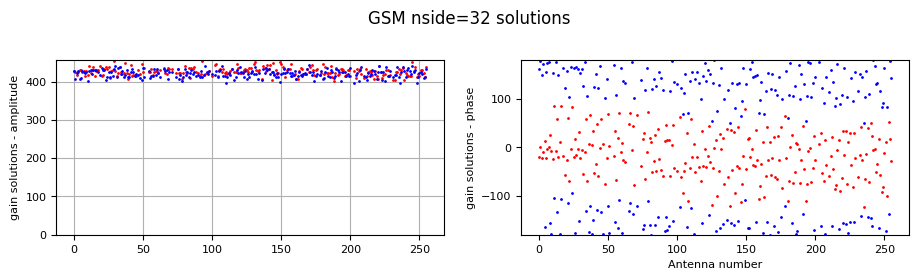

X,Y Median gains: 426.3, 422.7
X,Y RMS gain solutions: 10.6, 10.0
X,Y fractional RMS gain solutions: 0.02475, 0.02362


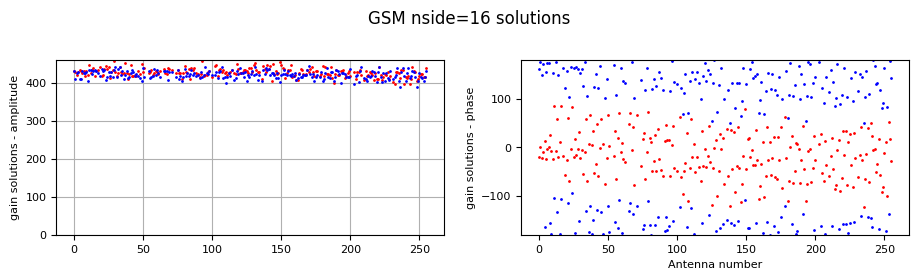

X,Y Median gains: 427.5, 421.6
X,Y RMS gain solutions: 11.2, 10.5
X,Y fractional RMS gain solutions: 0.02628, 0.02497


X,Y Median gains: 418.9, 416.9
X,Y RMS gain solutions: 15.3, 15.5
X,Y fractional RMS gain solutions: 0.03641, 0.03711
X,Y Median gains: 427.5, 421.6
X,Y RMS gain solutions: 11.2, 10.5
X,Y fractional RMS gain solutions: 0.02628, 0.02497


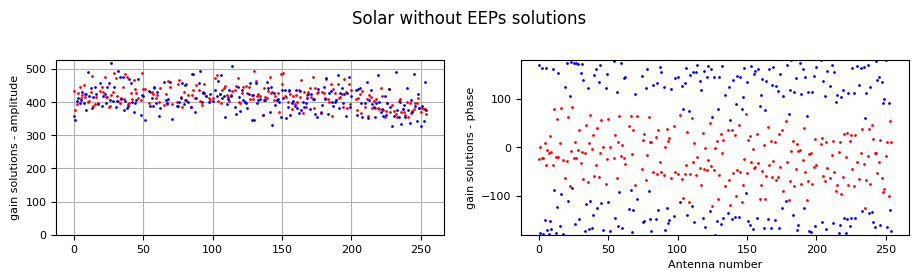

X,Y Median gains: 415.7, 405.3
X,Y RMS gain solutions: 30.3, 37.7
X,Y fractional RMS gain solutions: 0.07296, 0.09296


In [9]:
### Plot the GSM32 gains solutions

good_ant = np.isin(np.arange(nant), masked_antennas_gsm32, invert=True)
ant_list = np.arange(nant)[good_ant]

fig = plt.figure(figsize=[11,5])
plt.rcParams.update({'font.size': 8})
fig.suptitle("GSM nside=32 solutions", fontsize=12)
ax1=plt.subplot(2,2,1)
ax1.plot(ant_list, np.absolute(gain_gsm32[:, 0, 0]), "r.", markersize=2.0, label='X pol')
ax1.plot(ant_list, np.absolute(gain_gsm32[:, 1, 1]), "b.", markersize=2.0, label='Y pol')
plt.ylabel('gain solutions - amplitude')
ax1.set_ylim(ymin=0)
plt.grid()
ax1=plt.subplot(2,2,2)
ax1.plot(ant_list, np.angle(gain_gsm32[:, 0, 0], deg=True), "r.", markersize=2.0, label='X pol')
ax1.plot(ant_list, np.angle(gain_gsm32[:, 1, 1], deg=True), "b.", markersize=2.0, label='Y pol')
plt.ylabel('gain solutions - phase')
plt.ylim([-180.0,180.0])
plt.xlabel('Antenna number')

plt.show()

### Compute RMS scatter in the gain solutions
xgain_rms = np.std(np.abs(gain_gsm32[:, 0, 0]))
ygain_rms = np.std(np.abs(gain_gsm32[:, 1, 1]))
median_xgain = np.median(np.abs(gain_gsm32[:, 0, 0]))
median_ygain = np.median(np.abs(gain_gsm32[:, 1, 1]))
print(f"X,Y Median gains: {median_xgain:.1f}, {median_ygain:.1f}")
print(f"X,Y RMS gain solutions: {xgain_rms:.1f}, {ygain_rms:.1f}")
print(f"X,Y fractional RMS gain solutions: {xgain_rms/median_xgain:.5f}, {ygain_rms/median_ygain:.5f}")

### Plot the GSM16 gains solutions

good_ant = np.isin(np.arange(nant), masked_antennas_gsm16, invert=True)
ant_list = np.arange(nant)[good_ant]

fig = plt.figure(figsize=[11,5])
plt.rcParams.update({'font.size': 8})
fig.suptitle("GSM nside=16 solutions", fontsize=12)
ax1=plt.subplot(2,2,1)
ax1.plot(ant_list, np.absolute(gain_gsm16[:, 0, 0]), "r.", markersize=2.0, label='X pol')
ax1.plot(ant_list, np.absolute(gain_gsm16[:, 1, 1]), "b.", markersize=2.0, label='Y pol')
plt.ylabel('gain solutions - amplitude')
ax1.set_ylim(ymin=0)
plt.grid()
ax1=plt.subplot(2,2,2)
ax1.plot(ant_list, np.angle(gain_gsm16[:, 0, 0], deg=True), "r.", markersize=2.0, label='X pol')
ax1.plot(ant_list, np.angle(gain_gsm16[:, 1, 1], deg=True), "b.", markersize=2.0, label='Y pol')
plt.ylabel('gain solutions - phase')
plt.ylim([-180.0,180.0])
plt.xlabel('Antenna number')

plt.show()

### Compute RMS scatter in the gain solutions
xgain_rms = np.std(np.abs(gain_gsm16[:, 0, 0]))
ygain_rms = np.std(np.abs(gain_gsm16[:, 1, 1]))
median_xgain = np.median(np.abs(gain_gsm16[:, 0, 0]))
median_ygain = np.median(np.abs(gain_gsm16[:, 1, 1]))
print(f"X,Y Median gains: {median_xgain:.1f}, {median_ygain:.1f}")
print(f"X,Y RMS gain solutions: {xgain_rms:.1f}, {ygain_rms:.1f}")
print(f"X,Y fractional RMS gain solutions: {xgain_rms/median_xgain:.5f}, {ygain_rms/median_ygain:.5f}")

### Plot the Solar with EEPs gains solutions

good_ant = np.isin(np.arange(nant), masked_antennas_solar, invert=True)
ant_list = np.arange(nant)[good_ant]

fig = plt.figure(figsize=[11,5])
plt.rcParams.update({'font.size': 8})
fig.suptitle("Solar with EEPs solutions", fontsize=12)
ax1=plt.subplot(2,2,1)
ax1.plot(ant_list, np.absolute(gain_solar[:, 0, 0]), "r.", markersize=2.0, label='X pol')
ax1.plot(ant_list, np.absolute(gain_solar[:, 1, 1]), "b.", markersize=2.0, label='Y pol')
plt.ylabel('gain solutions - amplitude')
ax1.set_ylim(ymin=0)
plt.grid()
ax1=plt.subplot(2,2,2)
ax1.plot(ant_list, np.angle(gain_solar[:, 0, 0], deg=True), "r.", markersize=2.0, label='X pol')
ax1.plot(ant_list, np.angle(gain_solar[:, 1, 1], deg=True), "b.", markersize=2.0, label='Y pol')
plt.ylabel('gain solutions - phase')
plt.ylim([-180.0,180.0])
plt.xlabel('Antenna number')

plt.show()

### Compute RMS scatter in the gain solutions
xgain_rms = np.std(np.abs(gain_solar[:, 0, 0]))
ygain_rms = np.std(np.abs(gain_solar[:, 1, 1]))
median_xgain = np.median(np.abs(gain_solar[:, 0, 0]))
median_ygain = np.median(np.abs(gain_solar[:, 1, 1]))
print(f"X,Y Median gains: {median_xgain:.1f}, {median_ygain:.1f}")
print(f"X,Y RMS gain solutions: {xgain_rms:.1f}, {ygain_rms:.1f}")
print(f"X,Y fractional RMS gain solutions: {xgain_rms/median_xgain:.5f}, {ygain_rms/median_ygain:.5f}")

### Compute RMS scatter in the gain solutions
xgain_rms = np.std(np.abs(gain_gsm16[:, 0, 0]))
ygain_rms = np.std(np.abs(gain_gsm16[:, 1, 1]))
median_xgain = np.median(np.abs(gain_gsm16[:, 0, 0]))
median_ygain = np.median(np.abs(gain_gsm16[:, 1, 1]))
print(f"X,Y Median gains: {median_xgain:.1f}, {median_ygain:.1f}")
print(f"X,Y RMS gain solutions: {xgain_rms:.1f}, {ygain_rms:.1f}")
print(f"X,Y fractional RMS gain solutions: {xgain_rms/median_xgain:.5f}, {ygain_rms/median_ygain:.5f}")

### Plot the Solar without EEPs gains solutions

good_ant = np.isin(np.arange(nant), masked_antennas_rapid, invert=True)
ant_list = np.arange(nant)[good_ant]

fig = plt.figure(figsize=[11,5])
plt.rcParams.update({'font.size': 8})
fig.suptitle("Solar without EEPs solutions", fontsize=12)
ax1=plt.subplot(2,2,1)
ax1.plot(ant_list, np.absolute(gain_rapid[:, 0, 0]), "r.", markersize=2.0, label='X pol')
ax1.plot(ant_list, np.absolute(gain_rapid[:, 1, 1]), "b.", markersize=2.0, label='Y pol')
plt.ylabel('gain solutions - amplitude')
ax1.set_ylim(ymin=0)
plt.grid()
ax1=plt.subplot(2,2,2)
ax1.plot(ant_list, np.angle(gain_rapid[:, 0, 0], deg=True), "r.", markersize=2.0, label='X pol')
ax1.plot(ant_list, np.angle(gain_rapid[:, 1, 1], deg=True), "b.", markersize=2.0, label='Y pol')
plt.ylabel('gain solutions - phase')
plt.ylim([-180.0,180.0])
plt.xlabel('Antenna number')

plt.show()

### Compute RMS scatter in the gain solutions
xgain_rms = np.std(np.abs(gain_rapid[:, 0, 0]))
ygain_rms = np.std(np.abs(gain_rapid[:, 1, 1]))
median_xgain = np.median(np.abs(gain_rapid[:, 0, 0]))
median_ygain = np.median(np.abs(gain_rapid[:, 1, 1]))
print(f"X,Y Median gains: {median_xgain:.1f}, {median_ygain:.1f}")
print(f"X,Y RMS gain solutions: {xgain_rms:.1f}, {ygain_rms:.1f}")
print(f"X,Y fractional RMS gain solutions: {xgain_rms/median_xgain:.5f}, {ygain_rms/median_ygain:.5f}")


In [10]:
### Compute statistics of match between model and calibrated measurements

corrcoeff = np.zeros(4, "complex")

print("\nData calibrated with GSM nside=32 relative to the GSM nside=32:")
for k, POL_INDEX in enumerate([XX_idx, YY_idx, XY_idx, YX_idx]):
    yy_model = mdl_gsm32[:, POL_INDEX]
    yy_data = cal_gsm32[:, POL_INDEX]
    phase_diff = np.angle(yy_model / yy_data, deg=True)
    phase_std = np.std(phase_diff)
    amp_corrcoeff = np.corrcoef(np.abs(yy_data), np.abs(yy_model))
    corrcoeff[POL_INDEX] = amp_corrcoeff[0, 1] * np.exp(1j * phase_std*np.pi/180)
    print(f"{pol_label[POL_INDEX]}[CC] amp correlation coefficient, phase difference std: {amp_corrcoeff[0, 1]:.6f}, {phase_std:.6f}")

print("\nData calibrated with GSM nside=16 relative to the GSM nside=32:")
for k, POL_INDEX in enumerate([XX_idx, YY_idx, XY_idx, YX_idx]):
    # yy_model = mdl_gsm16[:, POL_INDEX]
    yy_model = mdl_gsm32[:, POL_INDEX]
    yy_data = cal_gsm16[:, POL_INDEX]
    phase_diff = np.angle(yy_model / yy_data, deg=True)
    phase_std = np.std(phase_diff)
    amp_corrcoeff = np.corrcoef(np.abs(yy_data), np.abs(yy_model))
    corrcoeff[POL_INDEX] = amp_corrcoeff[0, 1] * np.exp(1j * phase_std*np.pi/180)
    print(f"{pol_label[POL_INDEX]}[CC] amp correlation coefficient, phase difference std: {amp_corrcoeff[0, 1]:.6f}, {phase_std:.6f}")

print("\nData calibrated with the solar and EEPs model relative to the GSM nside=32:")
for k, POL_INDEX in enumerate([XX_idx, YY_idx, XY_idx, YX_idx]):
    # yy_model = mdl_solar[:, POL_INDEX]
    yy_model = mdl_gsm32[:, POL_INDEX]
    yy_data = cal_solar[:, POL_INDEX]
    phase_diff = np.angle(yy_model / yy_data, deg=True)
    phase_std = np.std(phase_diff)
    amp_corrcoeff = np.corrcoef(np.abs(yy_data), np.abs(yy_model))
    corrcoeff[POL_INDEX] = amp_corrcoeff[0, 1] * np.exp(1j * phase_std*np.pi/180)
    
    print(f"{pol_label[POL_INDEX]}[CC] amp correlation coefficient, phase difference std: {amp_corrcoeff[0, 1]:.6f}, {phase_std:.6f}")
print("\nData calibrated with the rapid solar model relative to the GSM nside=32:")
for k, POL_INDEX in enumerate([XX_idx, YY_idx, XY_idx, YX_idx]):
    # yy_model = mdl_rapid[:, POL_INDEX]
    yy_model = mdl_gsm32[:, POL_INDEX]
    yy_data = cal_rapid[:, POL_INDEX]
    phase_diff = np.angle(yy_model / yy_data, deg=True)
    phase_std = np.std(phase_diff)
    amp_corrcoeff = np.corrcoef(np.abs(yy_data), np.abs(yy_model))
    corrcoeff[POL_INDEX] = amp_corrcoeff[0, 1] * np.exp(1j * phase_std*np.pi/180)
    print(f"{pol_label[POL_INDEX]}[CC] amp correlation coefficient, phase difference std: {amp_corrcoeff[0, 1]:.6f}, {phase_std:.6f}")


Data calibrated with GSM nside=32 relative to the GSM nside=32:
XX[CC] amp correlation coefficient, phase difference std: 0.990332, 9.256199
YY[CC] amp correlation coefficient, phase difference std: 0.988931, 9.642376
XY[CC] amp correlation coefficient, phase difference std: 0.901049, 47.344270
YX[CC] amp correlation coefficient, phase difference std: 0.904175, 47.664025

Data calibrated with GSM nside=16 relative to the GSM nside=32:
XX[CC] amp correlation coefficient, phase difference std: 0.990207, 9.275857
YY[CC] amp correlation coefficient, phase difference std: 0.988833, 9.650785
XY[CC] amp correlation coefficient, phase difference std: 0.900868, 47.325825
YX[CC] amp correlation coefficient, phase difference std: 0.904120, 47.639608

Data calibrated with the solar and EEPs model relative to the GSM nside=32:
XX[CC] amp correlation coefficient, phase difference std: 0.988873, 9.233813
YY[CC] amp correlation coefficient, phase difference std: 0.986579, 9.559153
XY[CC] amp correlat

In [11]:
### Plot calibrated visibilities

plt.figure(figsize=[11,22])
plt.rcParams.update({'font.size': 8})

# for k, POL_INDEX in enumerate([XX_idx, YY_idx, XY_idx, YX_idx]):
for k, POL_INDEX in enumerate([XX_idx, XY_idx]):
    xmax = np.max(uvdist_gsm32)
    ymax = np.max(np.abs(mdl_gsm32[:, POL_INDEX]))

    ax1=plt.subplot(20, 2, k * 10 + 1)
    ax1.plot(uvdist_gsm32, np.abs(cal_gsm32[:, POL_INDEX]), "b*", markersize=0.1,alpha=1.0)
    plt.text(xmax*0.5,ymax*0.8, f"{pol_label[POL_INDEX]} calibrated with GSM nside=32")
    if k==0: plt.title('Amplitude')
    plt.ylabel('Calib amp (K)')
    plt.xlim([0.0, xmax])
    plt.ylim([0.0, ymax])
    ax1.axes.xaxis.set_ticklabels([])
    plt.grid()
    ax1=plt.subplot(20, 2, k * 10 + 2)
    ax1.plot(uvdist_gsm32, np.angle(cal_gsm32[:, POL_INDEX], deg=True), "b*", markersize=0.1,alpha=1.0)
    if k==0: plt.title('Phase')
    plt.ylabel('Calib phs (deg)')
    plt.xlim([0.0, xmax])
    ax1.axes.xaxis.set_ticklabels([])
    plt.grid()

    ax1=plt.subplot(20, 2, k * 10 + 3)
    ax1.plot(uvdist_gsm32, np.abs(mdl_gsm32[:, POL_INDEX]), "g*", markersize=0.1,alpha=1.0)
    plt.text(xmax*0.5,ymax*0.8, f"{pol_label[POL_INDEX]} GSM nside=32")
    plt.xlim([0.0, xmax])
    plt.ylim([0.0, ymax])
    ax1.axes.xaxis.set_ticklabels([])
    plt.grid()
    ax1=plt.subplot(20, 2, k * 10 + 4)
    ax1.plot(uvdist_gsm32, np.angle(mdl_gsm32[:, POL_INDEX], deg=True), "g*", markersize=0.1,alpha=1.0)
    plt.xlim([0.0, xmax])
    ax1.axes.xaxis.set_ticklabels([])
    plt.grid()

    ax1=plt.subplot(20, 2, k * 10 + 5)
    ax1.plot(uvdist_gsm16, np.abs(mdl_gsm16[:, POL_INDEX]), "c*", markersize=0.1,alpha=1.0)
    plt.text(xmax*0.5,ymax*0.8, f"{pol_label[POL_INDEX]} GSM nside=16 (Nvis = {len(mdl_gsm16[:, POL_INDEX])})")
    plt.xlim([0.0, xmax])
    plt.ylim([0.0, ymax])
    ax1.axes.xaxis.set_ticklabels([])
    plt.grid()
    ax1=plt.subplot(20, 2, k * 10 + 6)
    ax1.plot(uvdist_gsm16, np.angle(mdl_gsm16[:, POL_INDEX], deg=True), "c*", markersize=0.1,alpha=1.0)
    plt.xlim([0.0, xmax])
    ax1.axes.xaxis.set_ticklabels([])
    plt.grid()

    mask = wgt_solar[:, POL_INDEX] > 0
    ax1=plt.subplot(20, 2, k * 10 + 7)
    ax1.plot(uvdist_solar[mask], np.abs(mdl_solar[mask, POL_INDEX]), "m*", markersize=0.1,alpha=1.0)
    plt.text(xmax*0.5,ymax*0.8, f"{pol_label[POL_INDEX]} Solar model (Nvis = {len(mdl_solar[mask, POL_INDEX])})")
    plt.xlim([0.0, xmax])
    plt.ylim([0.0, ymax])
    if k < 1:
        ax1.axes.xaxis.set_ticklabels([])
    else:
        plt.xlabel('uv-dist (metres)')
    plt.grid()
    ax1=plt.subplot(20, 2, k * 10 + 8)
    ax1.plot(uvdist_solar[mask], np.angle(mdl_solar[mask, POL_INDEX], deg=True), "m*", markersize=0.1,alpha=1.0)
    plt.xlim([0.0, xmax])
    if k < 1:
        ax1.axes.xaxis.set_ticklabels([])
    else:
        plt.xlabel('uv-dist (metres)')
    plt.grid()

    mask = wgt_rapid[:, POL_INDEX] > 0
    ax1=plt.subplot(20, 2, k * 10 + 9)
    ax1.plot(uvdist_rapid[mask], np.abs(mdl_rapid[mask, POL_INDEX]), "r*", markersize=0.1,alpha=1.0)
    plt.text(xmax*0.5,ymax*0.8, f"{pol_label[POL_INDEX]} rapid model (Nvis = {len(mdl_rapid[mask, POL_INDEX])})")
    plt.xlim([0.0, xmax])
    plt.ylim([0.0, ymax])
    if k < 1:
        ax1.axes.xaxis.set_ticklabels([])
    else:
        plt.xlabel('uv-dist (metres)')
    plt.grid()
    ax1=plt.subplot(20, 2, k * 10 + 10)
    ax1.plot(uvdist_rapid[mask], np.angle(mdl_rapid[mask, POL_INDEX], deg=True), "r*", markersize=0.1,alpha=1.0)
    plt.xlim([0.0, xmax])
    if k < 1:
        ax1.axes.xaxis.set_ticklabels([])
    else:
        plt.xlabel('uv-dist (metres)')
    plt.grid()

plt.show()

In [12]:
### Plot amplitude of calibrated visibilities and residuals

plt.figure(figsize=[11,12])
plt.rcParams.update({'font.size': 8})

for k, POL_INDEX in enumerate([XX_idx, YY_idx, XY_idx, YX_idx]):
    xmax = np.max(uvdist_gsm32)
    ymax = np.max(np.abs(cal_gsm32[:, POL_INDEX]))

    ax1 = plt.subplot(4, 5, 5 * k + 1)
    ax1.plot(uvdist_gsm32, np.abs(mdl_gsm32[:, POL_INDEX]), "b*", markersize=0.1, label="GSM32 model")
    ax1.plot(uvdist_gsm32, np.abs(cal_gsm32[:, POL_INDEX]), "g*", markersize=0.1, label="GSM32 cal")
    ax1.plot(uvdist_gsm16, np.abs(cal_gsm16[:, POL_INDEX]), "c*", markersize=0.1, label="GSM16 cal")
    ax1.plot(uvdist_solar, np.abs(cal_solar[:, POL_INDEX]), "m*", markersize=0.1, label="Solar with EEPs cal")
    ax1.plot(uvdist_rapid, np.abs(cal_rapid[:, POL_INDEX]), "r*", markersize=0.1, label="Rapid solar cal")
    plt.title(f"|{pol_label[POL_INDEX]}|")
    plt.ylabel('Amplitude (K)')
    plt.xlim([0.0, xmax])
    plt.ylim([0.0, ymax])
    plt.grid()
    plt.legend()
    if k < 3:
        ax1.axes.xaxis.set_ticklabels([])
    else:
        plt.xlabel('uv-dist (metres)')

    # assume that this will have the largest residuals and use it to reset ymax
    res = cal_rapid[:, POL_INDEX] - mdl_gsm32[:, POL_INDEX]
    ymax = np.max(np.abs(res))

    ax1 = plt.subplot(4, 5, 5 * k + 2)
    res = cal_gsm32[:, POL_INDEX] - mdl_gsm32[:, POL_INDEX]
    ax1.plot(uvdist_gsm32, np.abs(res), "g*", markersize=0.1, label=f"Std. dev: {np.std(res):.2e}")
    plt.title("|GSM32-cal - GSM32|")
    plt.xlim([0.0, xmax])
    plt.ylim([0.0, ymax])
    plt.grid()
    plt.legend()
    if k < 3:
        ax1.axes.xaxis.set_ticklabels([])
    else:
        plt.xlabel('uv-dist (metres)')

    ax1 = plt.subplot(4, 5, 5 * k + 3)
    # res = cal_gsm16[:, POL_INDEX] - mdl_gsm16[:, POL_INDEX]
    res = cal_gsm16[:, POL_INDEX] - mdl_gsm32[:, POL_INDEX]
    ax1.plot(uvdist_gsm16, np.abs(res), "c*", markersize=0.1, label=f"Std. dev: {np.std(res):.2e}")
    plt.title("|GSM16-cal - GSM32|")
    plt.xlim([0.0, xmax])
    plt.ylim([0.0, ymax])
    plt.grid()
    plt.legend()
    if k < 3:
        ax1.axes.xaxis.set_ticklabels([])
    else:
        plt.xlabel('uv-dist (metres)')

    ax1 = plt.subplot(4, 5, 5 * k + 4)
    # res = cal_solar[:, POL_INDEX] - mdl_solar[:, POL_INDEX]
    res = cal_solar[:, POL_INDEX] - mdl_gsm32[:, POL_INDEX]
    ax1.plot(uvdist_solar, np.abs(res), "m*", markersize=0.1, label=f"Std. dev: {np.std(res):.2e}")
    plt.title("|Solar-cal - GSM32|")
    plt.xlim([0.0, xmax])
    plt.ylim([0.0, ymax])
    plt.grid()
    plt.legend()
    if k < 3:
        ax1.axes.xaxis.set_ticklabels([])
    else:
        plt.xlabel('uv-dist (metres)')

    ax1 = plt.subplot(4, 5, 5 * k + 5)
    # res = cal_rapid[:, POL_INDEX] - mdl_rapid[:, POL_INDEX]
    res = cal_rapid[:, POL_INDEX] - mdl_gsm32[:, POL_INDEX]
    ax1.plot(uvdist_rapid, np.abs(res), "r*", markersize=0.1, label=f"Std. dev: {np.std(res):.2e}")
    plt.title("|Rapid-cal - GSM32|")
    plt.xlim([0.0, xmax])
    plt.ylim([0.0, ymax])
    plt.grid()
    plt.legend()
    if k < 3:
        ax1.axes.xaxis.set_ticklabels([])
    else:
        plt.xlabel('uv-dist (metres)')

plt.show()

In [13]:
### Scatter plots measurements versus model

plt.figure(figsize=[13, 6])
plt.rcParams.update({'font.size': 8})

for k, POL_INDEX in enumerate([XX_idx, YY_idx, XY_idx, YX_idx]):
    yy_model = mdl_gsm32[:, POL_INDEX]
    yy_data = cal_gsm32[:, POL_INDEX]

    ax2 = plt.subplot(2, 4, k + 1, aspect="equal")
    ax2.plot(np.abs(yy_model), np.abs(yy_data), "g*", markersize=0.3,alpha=1.0)
    if k == 0:
        plt.xlabel("GSM32 amp")
        plt.ylabel("calibrated data (GSM32) amp")
    plt.title(f"{pol_label[POL_INDEX]} Pol")
    ax2.set_box_aspect(1)
    plt.grid()

    ax1 = plt.subplot(2, 4, k + 5, aspect="equal")    
    ax1.plot(np.angle(yy_model, deg=True), np.angle(yy_data, deg=True), "g*", markersize=0.3,alpha=1.0)
    if k == 0:
        plt.xlabel("GSM32 phase")
        plt.ylabel("calibrated data (GSM32) phase")
    plt.xlim([-180,180])
    plt.ylim([-180,180])
    ax1.set_box_aspect(1)
    plt.grid()

plt.show()

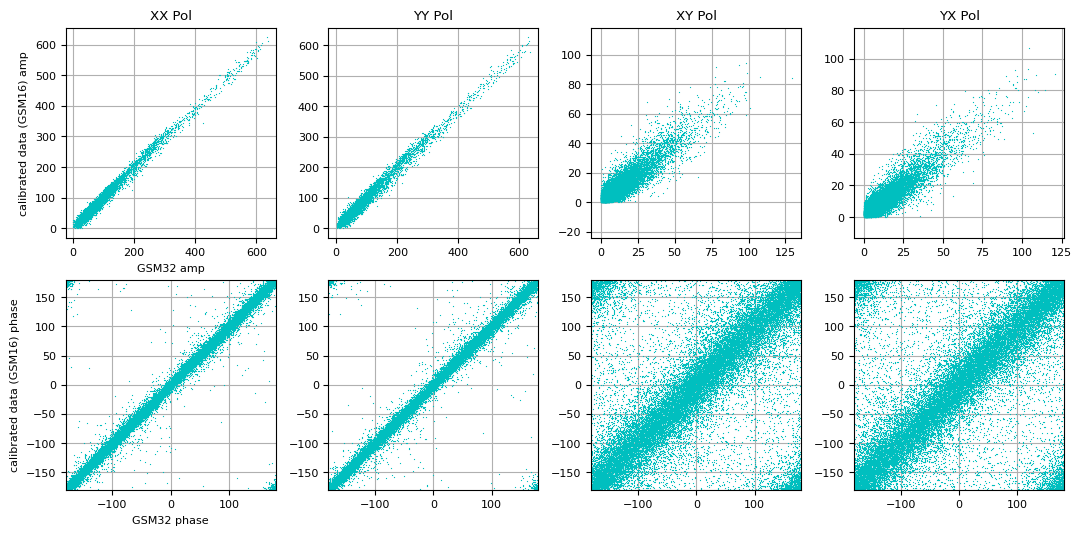

In [14]:
### Scatter plots measurements versus model

plt.figure(figsize=[13, 6])
plt.rcParams.update({'font.size': 8})

for k, POL_INDEX in enumerate([XX_idx, YY_idx, XY_idx, YX_idx]):
    # yy_model = mdl_gsm16[:, POL_INDEX]
    yy_model = mdl_gsm32[:, POL_INDEX]
    yy_data = cal_gsm16[:, POL_INDEX]

    ax2 = plt.subplot(2, 4, k + 1, aspect="equal")
    ax2.plot(np.abs(yy_model), np.abs(yy_data), "c*", markersize=0.3,alpha=1.0)
    if k == 0:
        plt.xlabel("GSM32 amp")
        plt.ylabel("calibrated data (GSM16) amp")
    plt.title(f"{pol_label[POL_INDEX]} Pol")
    ax2.set_box_aspect(1)
    plt.grid()

    ax1 = plt.subplot(2, 4, k + 5, aspect="equal")    
    ax1.plot(np.angle(yy_model, deg=True), np.angle(yy_data, deg=True), "c*", markersize=0.3,alpha=1.0)
    if k == 0:
        plt.xlabel("GSM32 phase")
        plt.ylabel("calibrated data (GSM16) phase")
    plt.xlim([-180,180])
    plt.ylim([-180,180])
    ax1.set_box_aspect(1)
    plt.grid()

plt.show()

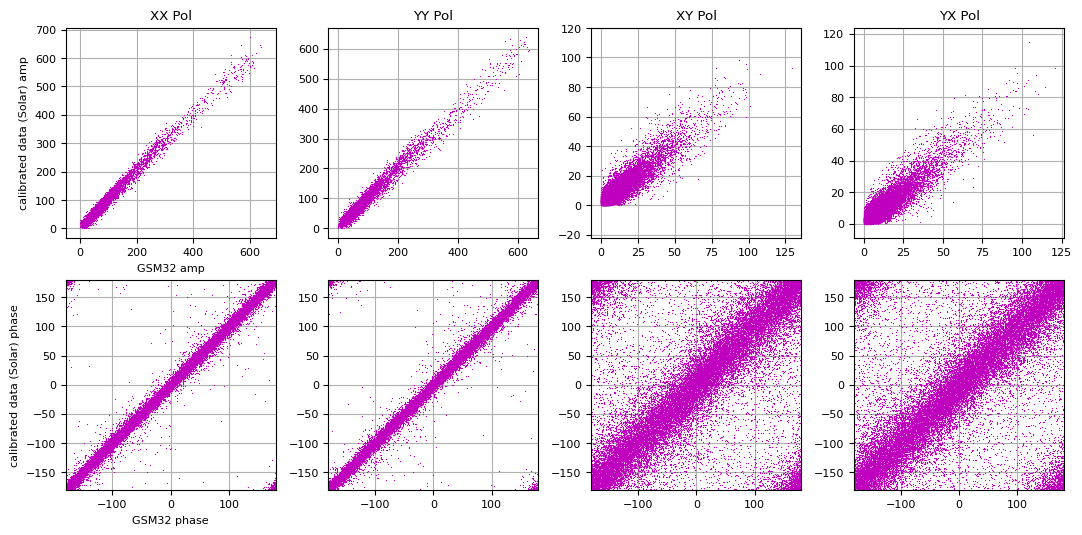

In [15]:
### Scatter plots measurements versus model

plt.figure(figsize=[13, 6])
plt.rcParams.update({'font.size': 8})

for k, POL_INDEX in enumerate([XX_idx, YY_idx, XY_idx, YX_idx]):
    # yy_model = mdl_solar[:, POL_INDEX]
    yy_model = mdl_gsm32[:, POL_INDEX]
    yy_data = cal_solar[:, POL_INDEX]

    ax2 = plt.subplot(2, 4, k + 1, aspect="equal")
    ax2.plot(np.abs(yy_model), np.abs(yy_data), "*m", markersize=0.3,alpha=1.0)
    if k == 0:
        plt.xlabel("GSM32 amp")
        plt.ylabel("calibrated data (Solar) amp")
    plt.title(f"{pol_label[POL_INDEX]} Pol")
    ax2.set_box_aspect(1)
    plt.grid()

    ax1 = plt.subplot(2, 4, k + 5, aspect="equal")    
    ax1.plot(np.angle(yy_model, deg=True), np.angle(yy_data, deg=True), "m*", markersize=0.3,alpha=1.0)
    if k == 0:
        plt.xlabel("GSM32 phase")
        plt.ylabel("calibrated data (Solar) phase")
    plt.xlim([-180,180])
    plt.ylim([-180,180])
    ax1.set_box_aspect(1)
    plt.grid()

plt.show()

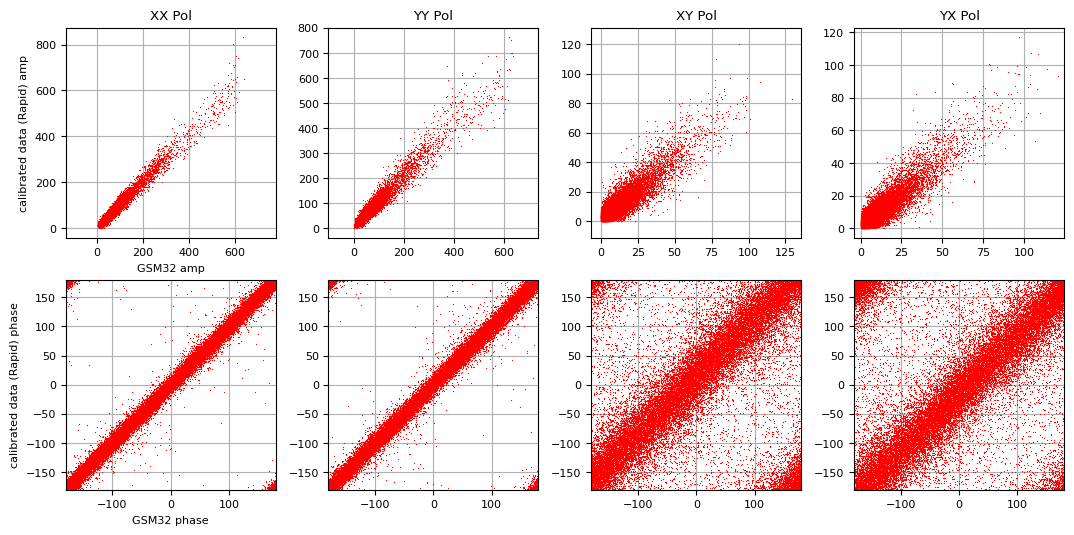

In [16]:
### Scatter plots measurements versus model

plt.figure(figsize=[13, 6])
plt.rcParams.update({'font.size': 8})

for k, POL_INDEX in enumerate([XX_idx, YY_idx, XY_idx, YX_idx]):
    # yy_model = mdl_rapid[:, POL_INDEX]
    yy_model = mdl_gsm32[:, POL_INDEX]
    yy_data = cal_rapid[:, POL_INDEX]

    ax2 = plt.subplot(2, 4, k + 1, aspect="equal")
    ax2.plot(np.abs(yy_model), np.abs(yy_data), "*r", markersize=0.3,alpha=1.0)
    if k == 0:
        plt.xlabel("GSM32 amp")
        plt.ylabel("calibrated data (Rapid) amp")
    plt.title(f"{pol_label[POL_INDEX]} Pol")
    ax2.set_box_aspect(1)
    plt.grid()

    ax1 = plt.subplot(2, 4, k + 5, aspect="equal")    
    ax1.plot(np.angle(yy_model, deg=True), np.angle(yy_data, deg=True), "r*", markersize=0.3,alpha=1.0)
    if k == 0:
        plt.xlabel("GSM32 phase")
        plt.ylabel("calibrated data (Rapid) phase")
    plt.xlim([-180,180])
    plt.ylim([-180,180])
    ax1.set_box_aspect(1)
    plt.grid()

plt.show()

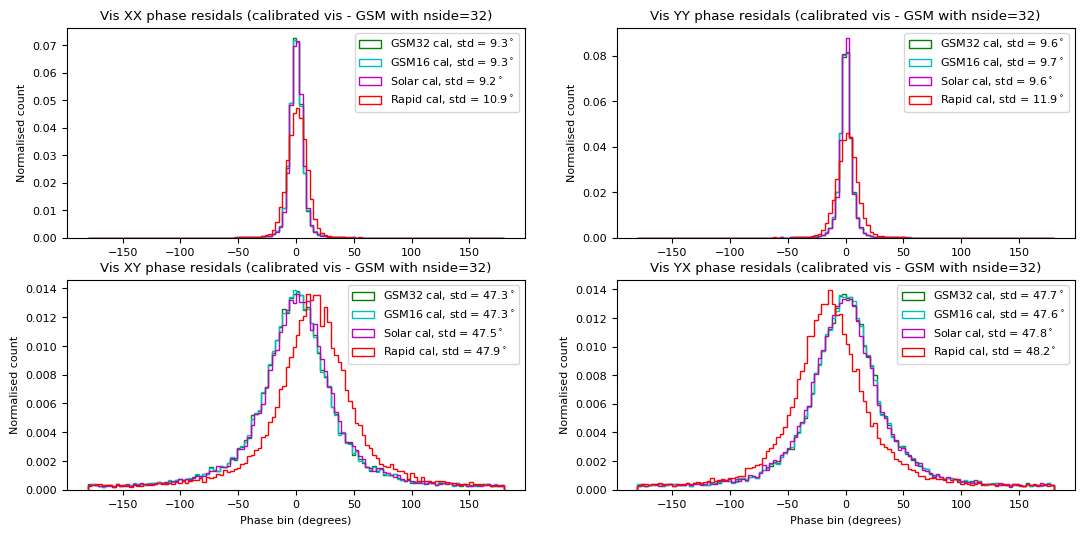

In [17]:
### Histograms of phase residuals

plt.figure(figsize=[13, 6])
plt.rcParams.update({'font.size': 8})

bins = range(-180, 181, 3)

for k, POL_INDEX in enumerate([XX_idx, YY_idx, XY_idx, YX_idx]):

    ax = plt.subplot(2, 2, k + 1)
    plt.title(f"Vis {pol_label[POL_INDEX]} phase residals (calibrated vis - GSM with nside=32)")
    if k > 1: plt.xlabel("Phase bin (degrees)")
    plt.ylabel("Normalised count")

    yy_model = mdl_gsm32[:, POL_INDEX]
    yy_data = cal_gsm32[:, POL_INDEX]
    angle_diff = (np.angle(yy_data) - np.angle(yy_model)) * 180.0 / np.pi
    angle_diff += 360 * (angle_diff < -180)
    angle_diff -= 360 * (angle_diff > +180)
    plt.hist(angle_diff, bins=bins, histtype="step", density=True, color="g", label=rf"GSM32 cal, std = {np.std(angle_diff):.1f}$^\circ$")

    # yy_model = mdl_gsm16[:, POL_INDEX]
    yy_model = mdl_gsm32[:, POL_INDEX]
    yy_data = cal_gsm16[:, POL_INDEX]
    angle_diff = (np.angle(yy_data) - np.angle(yy_model)) * 180.0 / np.pi
    angle_diff += 360 * (angle_diff < -180)
    angle_diff -= 360 * (angle_diff > +180)
    plt.hist(angle_diff, bins=bins, histtype="step", density=True, color="c", label=rf"GSM16 cal, std = {np.std(angle_diff):.1f}$^\circ$")

    # yy_model = mdl_solar[:, POL_INDEX]
    yy_model = mdl_gsm32[:, POL_INDEX]
    yy_data = cal_solar[:, POL_INDEX]
    angle_diff = (np.angle(yy_data) - np.angle(yy_model)) * 180.0 / np.pi
    angle_diff += 360 * (angle_diff < -180)
    angle_diff -= 360 * (angle_diff > +180)
    plt.hist(angle_diff, bins=bins, histtype="step", density=True, color="m", label=rf"Solar cal, std = {np.std(angle_diff):.1f}$^\circ$")

    # yy_model = mdl_rapid[:, POL_INDEX]
    yy_model = mdl_gsm32[:, POL_INDEX]
    yy_data = cal_rapid[:, POL_INDEX]
    angle_diff = (np.angle(yy_data) - np.angle(yy_model)) * 180.0 / np.pi
    angle_diff += 360 * (angle_diff < -180)
    angle_diff -= 360 * (angle_diff > +180)
    plt.hist(angle_diff, bins=bins, histtype="step", density=True, color="r", label=rf"Rapid cal, std = {np.std(angle_diff):.1f}$^\circ$")

    plt.legend()
